In [ ]:
# step 0: loading libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

Last data month (today): 2025-09


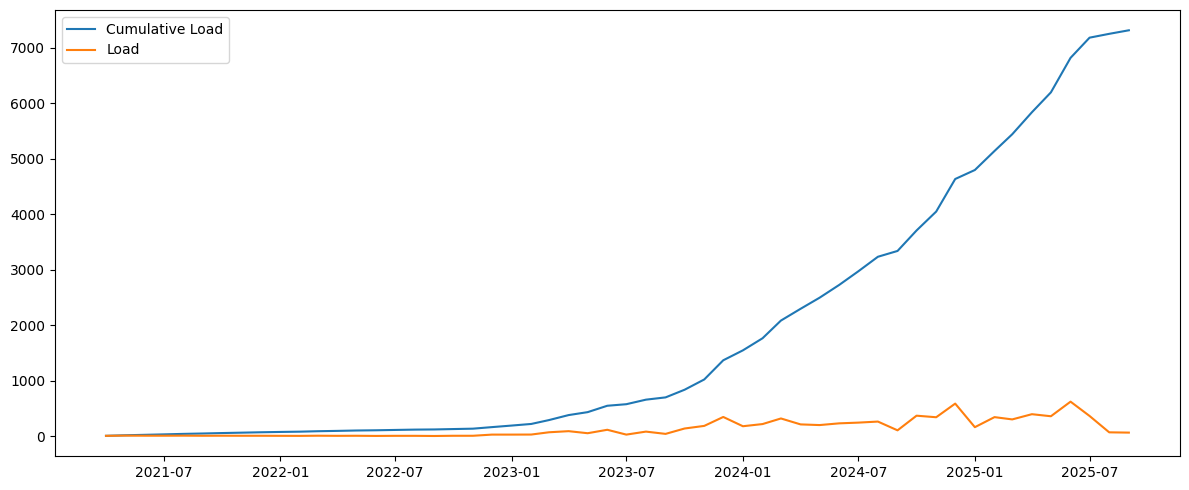

In [67]:
# step 1: collect monthly activity counts

conn = sqlite3.connect("database.sqlite")

posts_query = """
SELECT STRFTIME('%Y-%m', created_at) AS month, COUNT(1) AS posts
FROM posts
GROUP BY 1 ORDER BY 1;
"""
comments_query = """
SELECT STRFTIME('%Y-%m', created_at) AS month, COUNT(1) AS comments
FROM comments
GROUP BY 1 ORDER BY 1;
"""
users_query = """
SELECT STRFTIME('%Y-%m', created_at) AS month, COUNT(1) AS users
FROM users
GROUP BY 1 ORDER BY 1;
"""

df_posts = pd.read_sql_query(posts_query, conn, parse_dates=["month"]).set_index("month")
df_comments = pd.read_sql_query(comments_query, conn, parse_dates=["month"]).set_index("month")
df_users = pd.read_sql_query(users_query, conn, parse_dates=["month"]).set_index("month")

conn.close()

monthly = pd.concat([df_posts, df_comments, df_users], axis=1)
monthly["load"] = monthly.sum(axis=1)
monthly["cumulative_load"] = monthly["load"].cumsum()

last_month = monthly.index.max()
print(f"Last data month (today): {last_month.strftime('%Y-%m')}")

plt.figure(figsize=(12, 5))
plt.plot(monthly.index, monthly["cumulative_load"], label="Cumulative Load")
plt.plot(monthly.index, monthly["load"], label="Load")
plt.legend(); plt.tight_layout(); plt.show()


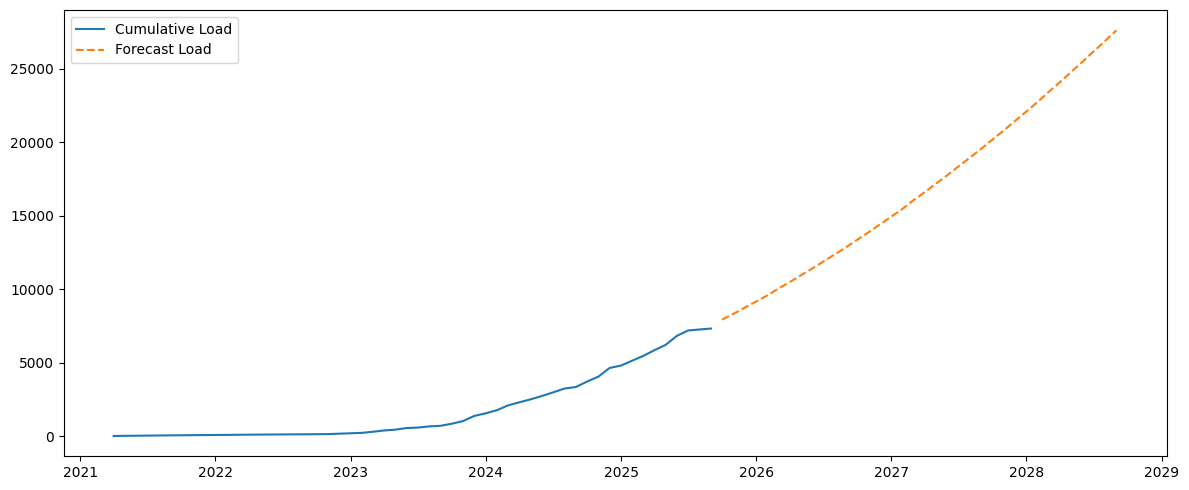

In [68]:
FORECAST_MONTHS = 36

X = np.arange(len(monthly)).reshape(-1, 1)
y = monthly["cumulative_load"].values

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

poly_model = LinearRegression().fit(X_poly, y)

future_idx = np.arange(len(monthly), len(monthly) + FORECAST_MONTHS).reshape(-1, 1)
future_poly = poly.transform(future_idx)
future_forecast = poly_model.predict(future_poly)

future_months = pd.date_range(
    start=last_month + pd.offsets.MonthBegin(1),
    periods=FORECAST_MONTHS,
    freq="MS"
)
fdf = pd.DataFrame(index=future_months)
fdf["forecast"] = future_forecast


plt.figure(figsize=(12, 5))
plt.plot(monthly.index, monthly["cumulative_load"], label="Cumulative Load")
plt.plot(fdf.index, fdf["forecast"], "--", label=f"Forecast Load")
plt.legend(); plt.tight_layout(); plt.show()

16 servers handle 7317.0 load units.
Forecast after 3 years: 73.0 servers needed.


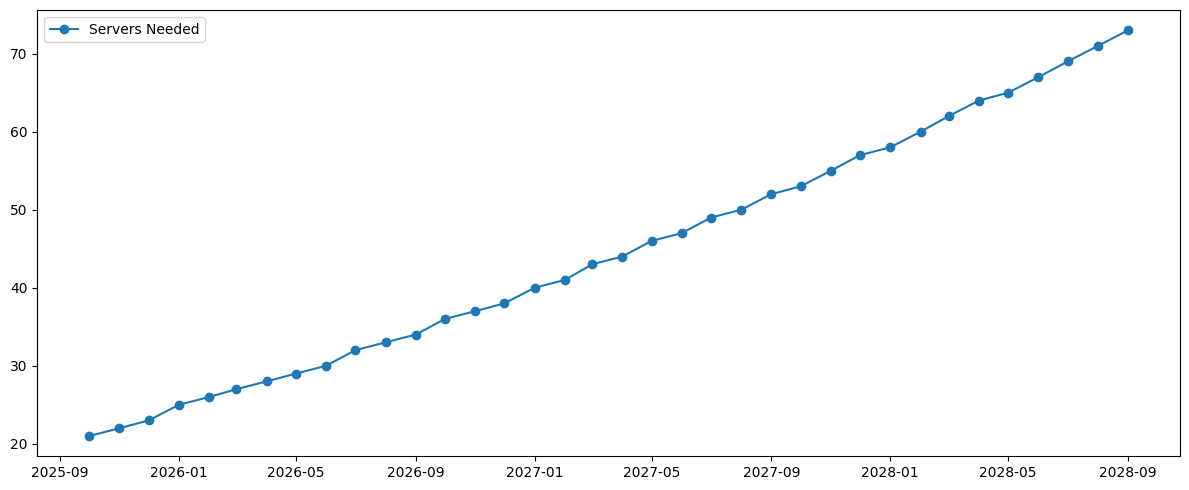

In [75]:
# step 3: estimate server needs
CURRENT_SERVERS = 16
REDUNDANCY = 1.20

last_month_load = monthly["cumulative_load"].iloc[-1]
load_per_server = last_month_load / CURRENT_SERVERS
fdf["servers_needed"] = np.ceil((fdf["forecast"] / load_per_server) * REDUNDANCY)

print(f"{CURRENT_SERVERS} servers handle {monthly['cumulative_load'].iloc[-1]} load units.")
print(f"Forecast after 3 years: {fdf['servers_needed'].iloc[-1]} servers needed.")

plt.figure(figsize=(12, 5))
plt.plot(fdf.index, fdf["servers_needed"], "o-", label="Servers Needed")
plt.legend(); plt.tight_layout(); plt.show()